# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.1.0
active_pynference         0.1.8
arviz                     0.19.0
asttokens                 2.4.1
attrs                     24.2.0
beautifulsoup4            4.12.3
certifi                   2024.7.4
chardet                   3.0.4
charset-normalizer        3.3.2
chex                      0.1.86
cloudpickle               3.0.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
corner                    2.2.2
cycler                    0.12.1
debugpy                   1.8.2
decorator                 5.1.1
deep-translator           1.11.4
dm-tree                   0.1.8
dnspython                 2.6.1
etils                     1.9.4
exceptiongroup            1.2.2
executing                 2.0.1
fastjsonschema            2.20.0
fastprogress              1.0.3
fonttools                 4.53.1
gast                      0.6.0
google               

In [2]:
import sys
import pickle 
import os
print(sys.prefix)
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd

from functools import partial

import importlib   # To import model files with poorly written names  ¯\_(ツ)_/¯
from tabulate import tabulate # to make pretty tables : 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training

# To extract the data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from analysis_tools.preprocess import get_preprocessed_data_from_df
from utils import remove_by_indices

# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from simulate.invert_model import invert_data_for_library_of_models

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Subjects with consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]

# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"

# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,
                                                              process_feedback_data_stream=True,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")

 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


In [4]:
# The initial datframe is the first tuple in our task result list of tuples : 
subjects_df = pd.DataFrame([entry[0] for entry in TASK_RESULTS])

# Avoid too many categories : 
subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

category_counts = subjects_df['Nationality'].value_counts()
threshold = 2
subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

# There was a single noise term for the whole training for each subject : 
subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in TASK_RESULTS]

# We add it to the df : 
subjects_df["feedback_noise_std"] = subject_noise_parameters

# # Create a pandas dataframe from the list of subject dictionnaries :

# In this dataframe, we're interested in sotring various kinds of data from the trials : 
# 1/ Data from the instruction phase

# 2/ Data from the feedback gauge :
# Timestep values :
all_subject_scores = [subjdata[2]["scoring"] for subjdata in TASK_RESULTS]
subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
# Real time gauge values :
subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in TASK_RESULTS] # Each element is a list of list os arrays (with varying shape)

# 3/ Data from the hidden grid :
# The grid for a specific trial: 
trial_grids = [entry[2]["process"]["grids"] for entry in TASK_RESULTS]
subjects_df["grid_layout"] = trial_grids
# Position value :
subject_positions = [entry[2]["process"]["positions"] for entry in TASK_RESULTS]
subjects_df["subject_positions"] = subject_positions

goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in TASK_RESULTS]
subjects_df["goal_position"] = goal_positions

def euclidian_distance(position,goal):
    return jnp.linalg.norm(position-goal,2)
gs = trial_grids[0][0].shape
maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


# 4/ Data from the realized actions :

# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"] # Constant across all subjects + conditions
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
# print(all_actions_data)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

Nactions = all_actions_data[...,0,0].size
Nmissed_actions = (~both_points_only).sum()
print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

subjects_df["raw_points"] = list(all_actions_data)


# Encoded barycenters :
barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
subjects_df["action_barycenters"] = list(barycenters)

# Encoded euclidian distance between points :
action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
subjects_df["action_distances"] = list(action_distances)

# Encoded evolution of point angles :
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
subjects_df["action_angles"] = list(angles)

# Encoded delays between stimuli, point1 and point2 :
all_action_delays = all_actions_data[...,-1,2]
unfit_actions = (all_action_delays<10)
subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

# Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
last_k_trials,last_t_timesteps = 3,5
all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


# And for the blind trial :
blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()

A total of 33/15950 actions were missed. (0.21 %)


### INVERSION META PARAMETERS

Observed data preprocessing and model hyperparameters settings.

In [5]:
RESULTS_SAVEPATH = os.path.join("results","704_map")

# environment constants :
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 6
TRUE_FEEDBACK_STD =  0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

# define the static dimensions of the problem :
No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES
MODEL_CONSTANTS = {
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
}


# If the points were too close, no angle was recorded :
# The limit was arbitrarily chosen at 7.5 :
min_dist_norm = 7.5/(np.sqrt(2)*750)

preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : N_FEEDBACK_OUTCOMES,
        "observation_ends_at_point" : 2
    }
}
# We can modify these at will

data = get_preprocessed_data_from_df(subjects_df,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default",
                            filter_angles_if_small_distance = True)

Out of the 15950.0 actions performed by our subjects, 15917.0 were 'valid' (99.8 %)
Out of the 15950.0 feedback sequences potentially observed by our subjects, 15950 were 'valid' (100.0 %)


In [6]:
formatted_stimuli= [data["observations"]["vect"][1]]
bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
rewards = jnp.array(data["observations"]["deltas"])

actions = {}
for action_dim in ["position","distance","angle"]:
    actions[action_dim] = jnp.array(data["actions"]["vect"][action_dim])[:,:-1,:,:] # Ignore the last trial

Nsubj,Ntrials,Nactions,_ = actions[action_dim].shape
timesteps = jnp.broadcast_to(jnp.arange(Nactions+1),(Nsubj,Ntrials,Nactions+1))

data_all_subjects = (formatted_stimuli,bool_stimuli,rewards,actions,timesteps)



formatted_stimuli,_,_,_,_ = data_all_subjects
Nsubj,Ntrials,Ntimesteps,_ = formatted_stimuli[0].shape

## Defining the fitted models

Behaviour of one static biais agent with uniform biais :


Let's initialize a set of parameter ranges and priors for a plethora of models !

In [7]:

# Predefine the priors for MAP approaches
zero_one_uni = tfd.Uniform(low=-1e-5,high=1.0+1e-5)  # Bounds may be a bit finnicky and cause loglikelihood overflows
zero_big_uni = tfd.Uniform(low=-1e-5,high=1e3+1e-5) 

beta_biais_prior = tfd.Normal(50,20)
beta_Q_prior = tfd.Normal(50,20)
beta_omega_prior = tfd.Normal(50,20)




MODEL_LIBRARY = {}

# Random agent -------------------------------------------------------------------------------------------------------
# Random agent : selects actions randomly
from agents.agent_random import agent as random_agent
MODEL_LIBRARY["random"] ={
    "model" : partial(random_agent,constants=MODEL_CONSTANTS),
    "ranges" : {"angle":None,"position":None,"distance":None},
    "priors": {"angle":None,"position":None,"distance":None},
    "bypass" : True,  # Don't try to invert this one, the log likelihood is fixed !
    "tags": ["random"]
}


# Rescorla wagner agents ---------------------------------------------------------------------------------------------
# Independent model weights : ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
model_module = importlib.import_module("agents.agent_i-rw")
MODEL_LIBRARY["i_rw"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
            }
        },
    "tags": ["rw"]
}

# Assymetric learning rates : 
model_module = importlib.import_module("agents.agent_i-rwa")
MODEL_LIBRARY["i_rwa"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
            },
            "position":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
            },
            "distance":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
            }
        },
    "tags": ["rw","assymetric"]
}

# Adding (static) biaises :
model_module = importlib.import_module("agents.agent_i-rw+b")
MODEL_LIBRARY["i_rw+b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        },
    "tags": ["rw","static_biais"]
}


model_module = importlib.import_module("agents.agent_i-rwa+b")
MODEL_LIBRARY["i_rwa+b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        },
    "tags": ["rw","assymetric","static_biais"]
}

# Adding (initial) biaises :
model_module = importlib.import_module("agents.agent_i-rw&b")
MODEL_LIBRARY["i_rw&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            }
        },
    "tags": ["rw","initial_biais"]
}

model_module = importlib.import_module("agents.agent_i-rwa&b")
MODEL_LIBRARY["i_rwa&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "angle":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "position":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "distance":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            }
        },
    "tags": ["rw","assymetric","initial_biais"]
}

# Attention focusing agents that need to pick an action modality as well as an action :
# 1 mechanism to prune attention with rw models : directly (from q value). This can be hard (directly from the q table)
# or smooth (the value extracted from the q table is used to update an estimate omegaq)
model_module = importlib.import_module("agents.agent_i-rw&b_directq")
MODEL_LIBRARY["i_rw&b_directq+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            }
        },
    "tags": ["rw","initial_biais","focused_action_selection","focused_learning","directq"]
}

model_module = importlib.import_module("agents.agent_i-rw&b_directq")
MODEL_LIBRARY["i_rw&b_directq"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            }
        },
    "tags": ["rw","initial_biais","focused_action_selection","directq"]
}

model_module = importlib.import_module("agents.agent_i-rw+b_directq")
MODEL_LIBRARY["i_rw+b_directq+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
    "priors": {
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        },
    "tags": ["rw","static_biais","focused_action_selection","focused_learning","directq"]
}

model_module = importlib.import_module("agents.agent_i-rw+b_directq")
MODEL_LIBRARY["i_rw+b_directq"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
    "priors": {
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        },
    "tags": ["rw","static_biais","focused_action_selection","directq"]
}

# Variable action modality selection scheme :
model_module = importlib.import_module("agents.agent_i-rw&b_omegaq")
MODEL_LIBRARY["i_rw&b_omegaq+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega" : zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            }
        },
    "tags": ["rw","initial_biais","focused_action_selection","focused_learning","omegaq"]
}

model_module = importlib.import_module("agents.agent_i-rw&b_omegaq")
MODEL_LIBRARY["i_rw&b_omegaq"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega" : zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "initial_q" : zero_one_uni 
            }
        },
    "tags": ["rw","initial_biais","focused_action_selection","omegaq"]
}

model_module = importlib.import_module("agents.agent_i-rw+b_omegaq")
MODEL_LIBRARY["i_rw+b_omegaq+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        },
    "tags": ["rw","static_biais","focused_action_selection","focused_learning","omegaq"]
}

model_module = importlib.import_module("agents.agent_i-rw+b_omegaq")
MODEL_LIBRARY["i_rw+b_omegaq"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        },
    "tags": ["rw","static_biais","focused_action_selection","omegaq"]
}

# Mixed model weights : ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Mixed weights mean that the learning rate / action selection temperature is the same across all action dimensions
# This only makes sense for the action modality selection schemes : 
model_module = importlib.import_module("agents.agent_m-rw&b")
MODEL_LIBRARY["m_rw&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","initial_biais"]
}

model_module = importlib.import_module("agents.agent_m-rw+b")
MODEL_LIBRARY["m_rw+b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","static_biais"]
}

model_module = importlib.import_module("agents.agent_m-rw&b_omegaq")
MODEL_LIBRARY["m_rw&b_omegaq+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","initial_biais","focused_learning","focused_action_selection","omegaq"]
}

model_module = importlib.import_module("agents.agent_m-rw&b_omegaq")
MODEL_LIBRARY["m_rw&b_omegaq"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","initial_biais","focused_action_selection","omegaq"]
}


model_module = importlib.import_module("agents.agent_m-rw+b_omegaq")
MODEL_LIBRARY["m_rw+b_omegaq+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","static_biais","focused_learning","focused_action_selection","omegaq"]
}

model_module = importlib.import_module("agents.agent_m-rw+b_omegaq")
MODEL_LIBRARY["m_rw+b_omegaq"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","static_biais","focused_action_selection","omegaq"]
}

# Finally, we can add an initial prior to the action modality estimate of our agents !
model_module = importlib.import_module("agents.agent_m-rw&b_omegaq&b")
MODEL_LIBRARY["m_rw&b_omegaq&b+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","initial_biais","initial_omega_biais","focused_learning","focused_action_selection","omegaq"]
}

model_module = importlib.import_module("agents.agent_m-rw&b_omegaq&b")
MODEL_LIBRARY["m_rw&b_omegaq&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","initial_biais","initial_omega_biais","focused_action_selection","omegaq"]
}

model_module = importlib.import_module("agents.agent_m-rw+b_omegaq&b")
MODEL_LIBRARY["m_rw+b_omegaq&b+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","static_biais","initial_omega_biais","focused_action_selection","focused_learning","omegaq"]
}

model_module = importlib.import_module("agents.agent_m-rw+b_omegaq&b")
MODEL_LIBRARY["m_rw+b_omegaq&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["rw","mixed","static_biais","initial_omega_biais","focused_action_selection","omegaq"]
}

# latent states Q-Learning agents --------------------------------------------------------------------------------------=
# Independent model weights : ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
model_module = importlib.import_module("agents.agent_i-latQL+b")
MODEL_LIBRARY["i_latQL+b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3]),
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "position":{
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3]),
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3]),
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "biais" : zero_one_uni,  # No priors on the individual biaises !
                "beta_biais" : beta_biais_prior,
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "position":{
                "biais" : zero_one_uni,  # No priors on the individual biaises !
                "beta_biais" : beta_biais_prior,
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "distance":{
                "biais" : zero_one_uni,  # No priors on the individual biaises !
                "beta_biais" : beta_biais_prior,
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            }
        },
    "tags": ["latql","static_biais"]
}

model_module = importlib.import_module("agents.agent_i-latQL&b")
MODEL_LIBRARY["i_latQL&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "initial_q" : jnp.array([-10,10,9]),
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9]),
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4]),
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "initial_q" : zero_one_uni,  # No priors on the individual biaises !
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "position":{
                "initial_q" : zero_one_uni,  # No priors on the individual biaises !
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "distance":{
                "initial_q" : zero_one_uni,  # No priors on the individual biaises !
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            }
        },
    "tags": ["latql","initial_biais"]
}

model_module = importlib.import_module("agents.agent_i-latQLa+b")
MODEL_LIBRARY["i_latQLa+b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3]),
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "position":{
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3]),
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3]),
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "biais" : zero_one_uni,  # No priors on the individual biaises !
                "beta_biais" : beta_biais_prior,
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "position":{
                "biais" : zero_one_uni,  # No priors on the individual biaises !
                "beta_biais" : beta_biais_prior,
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "distance":{
                "biais" : zero_one_uni,  # No priors on the individual biaises !
                "beta_biais" : beta_biais_prior,
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            }
        },
    "tags": ["latql","static_biais","assymetric"]
}

model_module = importlib.import_module("agents.agent_i-latQLa&b")
MODEL_LIBRARY["i_latQLa&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS),
    "ranges" : {
            "angle":{
                "initial_q" : jnp.array([-10,10,9]),
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9]),
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4]),
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "transition_alpha" :  jnp.array([-10,10]),
                "perception_sigma" : jnp.array([-3,3]),
                "gamma_generalize" : jnp.array([-3,3])
            }
        },
    "priors": {
            "angle":{
                "initial_q" : zero_one_uni,  # No priors on the individual biaises !
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "position":{
                "initial_q" : zero_one_uni,  # No priors on the individual biaises !
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            },
            "distance":{
                "initial_q" : zero_one_uni,  # No priors on the individual biaises !
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "transition_alpha" : zero_one_uni,
                "perception_sigma" : zero_big_uni,
                "gamma_generalize" : zero_big_uni
            }
        },
    "tags": ["latql","initial_biais","assymetric"]
}


# And the mixed models : 
model_module = importlib.import_module("agents.agent_m-latQL+b_omegac")
MODEL_LIBRARY["m_latQL+b_omegac+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","static_biais","focused_action_selection","focused_learning","omegac"]
}

model_module = importlib.import_module("agents.agent_m-latQL+b_omegac")
MODEL_LIBRARY["m_latQL+b_omegac"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","static_biais","focused_action_selection","omegac"]
}


model_module = importlib.import_module("agents.agent_m-latQL+b_omegac&b")
MODEL_LIBRARY["m_latQL+b_omegac&b+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","static_biais","initial_omega_biais","focused_action_selection","focused_learning","omegac"]
}

model_module = importlib.import_module("agents.agent_m-latQL+b_omegac&b")
MODEL_LIBRARY["m_latQL+b_omegac&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "beta_biais" : jnp.array([-3,3]),
            "angle":{
                "biais" : jnp.array([-10,10,9])
            },
            "position":{
                "biais" : jnp.array([-10,10,9])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "beta_biais" : beta_biais_prior,
            "angle":{
                "biais" : zero_one_uni,
            },
            "position":{
                "biais" : zero_one_uni,
            },
            "distance":{
                "biais" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","static_biais","initial_omega_biais","focused_action_selection","omegac"]
}

model_module = importlib.import_module("agents.agent_m-latQL&b_omegac")
MODEL_LIBRARY["m_latQL&b_omegac+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","initial_biais","focused_action_selection","focused_learning","omegac"]
}

model_module = importlib.import_module("agents.agent_m-latQL&b_omegac")
MODEL_LIBRARY["m_latQL&b_omegac"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","initial_biais","focused_action_selection","omegac"]
}



model_module = importlib.import_module("agents.agent_m-latQL&b_omegac&b")
MODEL_LIBRARY["m_latQL&b_omegac&b+fl"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=True),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","initial_biais","initial_omega_biais","focused_action_selection","focused_learning","omegac"]
}

model_module = importlib.import_module("agents.agent_m-latQL&b_omegac&b")
MODEL_LIBRARY["m_latQL&b_omegac&b"] ={
    "model" : partial(model_module.agent,constants=MODEL_CONSTANTS,focused_learning=False),
    "ranges" : {
            "initial_omega" : jnp.array([-10,10,3]),
            "alpha_omega": jnp.array([-10,10]),
            "beta_omega" : jnp.array([-3,3]),
            "alpha_Q" : jnp.array([-10,10]),
            "beta_Q" : jnp.array([-3,3]),
            "transition_alpha" :  jnp.array([-10,10]),
            "perception_sigma" : jnp.array([-3,3]),
            "gamma_generalize" : jnp.array([-3,3]),
            "angle":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "position":{
                "initial_q" : jnp.array([-10,10,9])
            },
            "distance":{
                "initial_q" : jnp.array([-10,10,4])
            }
        },
    "priors": {
            "initial_omega" : zero_one_uni,
            "alpha_omega": zero_one_uni,
            "beta_omega" : beta_omega_prior,
            "alpha_Q" : zero_one_uni,
            "beta_Q" : beta_Q_prior,
            "transition_alpha" : zero_one_uni,
            "perception_sigma" : zero_big_uni,
            "gamma_generalize" : zero_big_uni,
            "angle":{
                "initial_q" : zero_one_uni,
            },
            "position":{
                "initial_q" : zero_one_uni,
            },
            "distance":{
                "initial_q" : zero_one_uni,
            }
        },
    "tags": ["latql","mixed","initial_biais","initial_omega_biais","focused_action_selection","omegac"]
}


Counting the amount of parameters in all models !

In [8]:
# Check for duplicates :
namelist = list(MODEL_LIBRARY.keys())
print(len(namelist) == len(set(namelist)))


# Show the amount of parameter for each model :
from simulate.compute_likelihood_full_actions import get_random_parameter_set

# Get a typical hyperparameter dictionnary for each model :
parameter_count_list = []
for model_name,model_contents in MODEL_LIBRARY.items():   
    parameter_set_tree = get_random_parameter_set(model_contents["ranges"],jr.PRNGKey(0))

    
    vls,_ = (jax.tree.flatten(tree_map(lambda x : x.size,parameter_set_tree)))    
    
    nbr,_ = (jax.tree.flatten(tree_map(lambda x : x.shape[0],parameter_set_tree)))    
    
    parameter_count_list.append([model_name,sum(vls),sum(nbr)])#"{}({:.1f} %)".format(sum(nbr),(sum(nbr)+1e-10)/(sum(vls)+1e-10)*100)])

print(tabulate(parameter_count_list, headers=['model name', '# of parameters \n(scalar values)','# of parameters \n(distinct variables)'], tablefmt='orgtbl'))   
 

True
| model name            |   # of parameters  |       # of parameters  |
|                       |    (scalar values) |   (distinct variables) |
|-----------------------+--------------------+------------------------|
| random                |                  0 |                      0 |
| i_rw                  |                  6 |                      6 |
| i_rwa                 |                  9 |                      9 |
| i_rw+b                |                 31 |                     12 |
| i_rwa+b               |                 34 |                     15 |
| i_rw&b                |                 28 |                      9 |
| i_rwa&b               |                 31 |                     12 |
| i_rw&b_directq+fl     |                 29 |                     10 |
| i_rw&b_directq        |                 29 |                     10 |
| i_rw+b_directq+fl     |                 32 |                     13 |
| i_rw+b_directq        |                 32 |             

The main issue we run into with this method is its heavy memory consumption. To alleviate the problem, we can invert each subject successively for the more demanding models. This is what the "vectorize_fit=False" line does : 

In [9]:

for model_name,model_contents in MODEL_LIBRARY.items():
    
    # RW models are quite cheap to invert :
    if "rw" in model_contents["tags"]:
        model_contents["vectorize_fit"] = True 
        model_contents["n_heads"] = 20
        model_contents["n_steps"] = 500
    
    # In the absence of parrallelized computation, the latent Q-Learning models are quite expensive to invert :
    if "latql" in model_contents["tags"]:
        model_contents["vectorize_fit"] = False 
        model_contents["n_heads"] = 10
        model_contents["n_steps"] = 300

In [10]:
 
# If we only want to train a subset :     
# reduced_library = {}
# for model_name,model_contents in MODEL_LIBRARY.items():          
#     # if ('random' in model_contents["tags"]) or ("rw" in model_contents["tags"]):
    
#     if "latql" in model_contents["tags"]:
#         reduced_library[model_name] = model_contents


reduced_library = MODEL_LIBRARY
print(reduced_library.keys())

RESULTS = invert_data_for_library_of_models(data_all_subjects,reduced_library,method="map",
                                  standard_n_heads=20,standard_n_steps=500,lr=5e-2,
                                  rngkey=jr.PRNGKey(100),
                                  save=True,save_directory=RESULTS_SAVEPATH,override=False)

dict_keys(['random', 'i_rw', 'i_rwa', 'i_rw+b', 'i_rwa+b', 'i_rw&b', 'i_rwa&b', 'i_rw&b_directq+fl', 'i_rw&b_directq', 'i_rw+b_directq+fl', 'i_rw+b_directq', 'i_rw&b_omegaq+fl', 'i_rw&b_omegaq', 'i_rw+b_omegaq+fl', 'i_rw+b_omegaq', 'm_rw&b', 'm_rw+b', 'm_rw&b_omegaq+fl', 'm_rw&b_omegaq', 'm_rw+b_omegaq+fl', 'm_rw+b_omegaq', 'm_rw&b_omegaq&b+fl', 'm_rw&b_omegaq&b', 'm_rw+b_omegaq&b+fl', 'm_rw+b_omegaq&b', 'i_latQL+b', 'i_latQL&b', 'i_latQLa+b', 'i_latQLa&b', 'm_latQL+b_omegac+fl', 'm_latQL+b_omegac', 'm_latQL+b_omegac&b+fl', 'm_latQL+b_omegac&b', 'm_latQL&b_omegac+fl', 'm_latQL&b_omegac', 'm_latQL&b_omegac&b+fl', 'm_latQL&b_omegac&b'])
     -> Agent : random
     -> Agent : i_rw
     -> Agent : i_rwa
     -> Agent : i_rw+b
     -> Agent : i_rwa+b
     -> Agent : i_rw&b
     -> Agent : i_rwa&b
     -> Agent : i_rw&b_directq+fl
     -> Agent : i_rw&b_directq
     -> Agent : i_rw+b_directq+fl
     -> Agent : i_rw+b_directq
     -> Agent : i_rw&b_omegaq+fl
     -> Agent : i_rw&b_omegaq
    

A total of 37 models were inverted ! 
random
i_rw
(145, 20, 500)
i_rwa
(145, 20, 500)
i_rw+b
(145, 20, 500)
i_rwa+b
(145, 20, 500)
i_rw&b
(145, 20, 500)
i_rwa&b
(145, 20, 500)
i_rw&b_directq+fl
(145, 20, 500)
i_rw&b_directq
(145, 20, 500)
i_rw+b_directq+fl
(145, 20, 500)
i_rw+b_directq
(145, 20, 500)
i_rw&b_omegaq+fl
(145, 20, 500)
i_rw&b_omegaq
(145, 20, 500)
i_rw+b_omegaq+fl
(145, 20, 500)
i_rw+b_omegaq
(145, 20, 500)
m_rw&b
(145, 20, 500)
m_rw+b
(145, 20, 500)
m_rw&b_omegaq+fl
(145, 20, 500)
m_rw&b_omegaq
(145, 20, 500)
m_rw+b_omegaq+fl
(145, 20, 500)
m_rw+b_omegaq
(145, 20, 500)
m_rw&b_omegaq&b+fl
(145, 20, 500)
m_rw&b_omegaq&b
(145, 20, 500)
m_rw+b_omegaq&b+fl
(145, 20, 500)
m_rw+b_omegaq&b
(145, 20, 500)
i_latQL+b
(145, 10, 300)
i_latQL&b
(145, 10, 300)
i_latQLa+b
(145, 10, 300)
i_latQLa&b
(145, 10, 300)
m_latQL+b_omegac+fl
(145, 10, 300)
m_latQL+b_omegac
(145, 10, 300)
m_latQL+b_omegac&b+fl
(145, 10, 300)
m_latQL+b_omegac&b
(145, 10, 300)
m_latQL&b_omegac+fl
(145, 10, 300)
m_lat

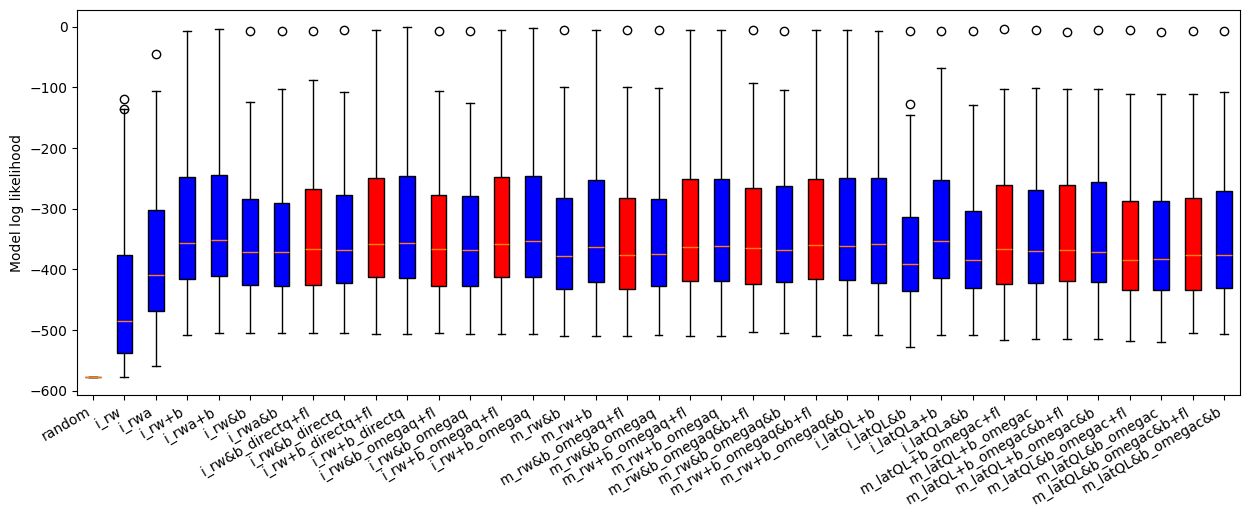

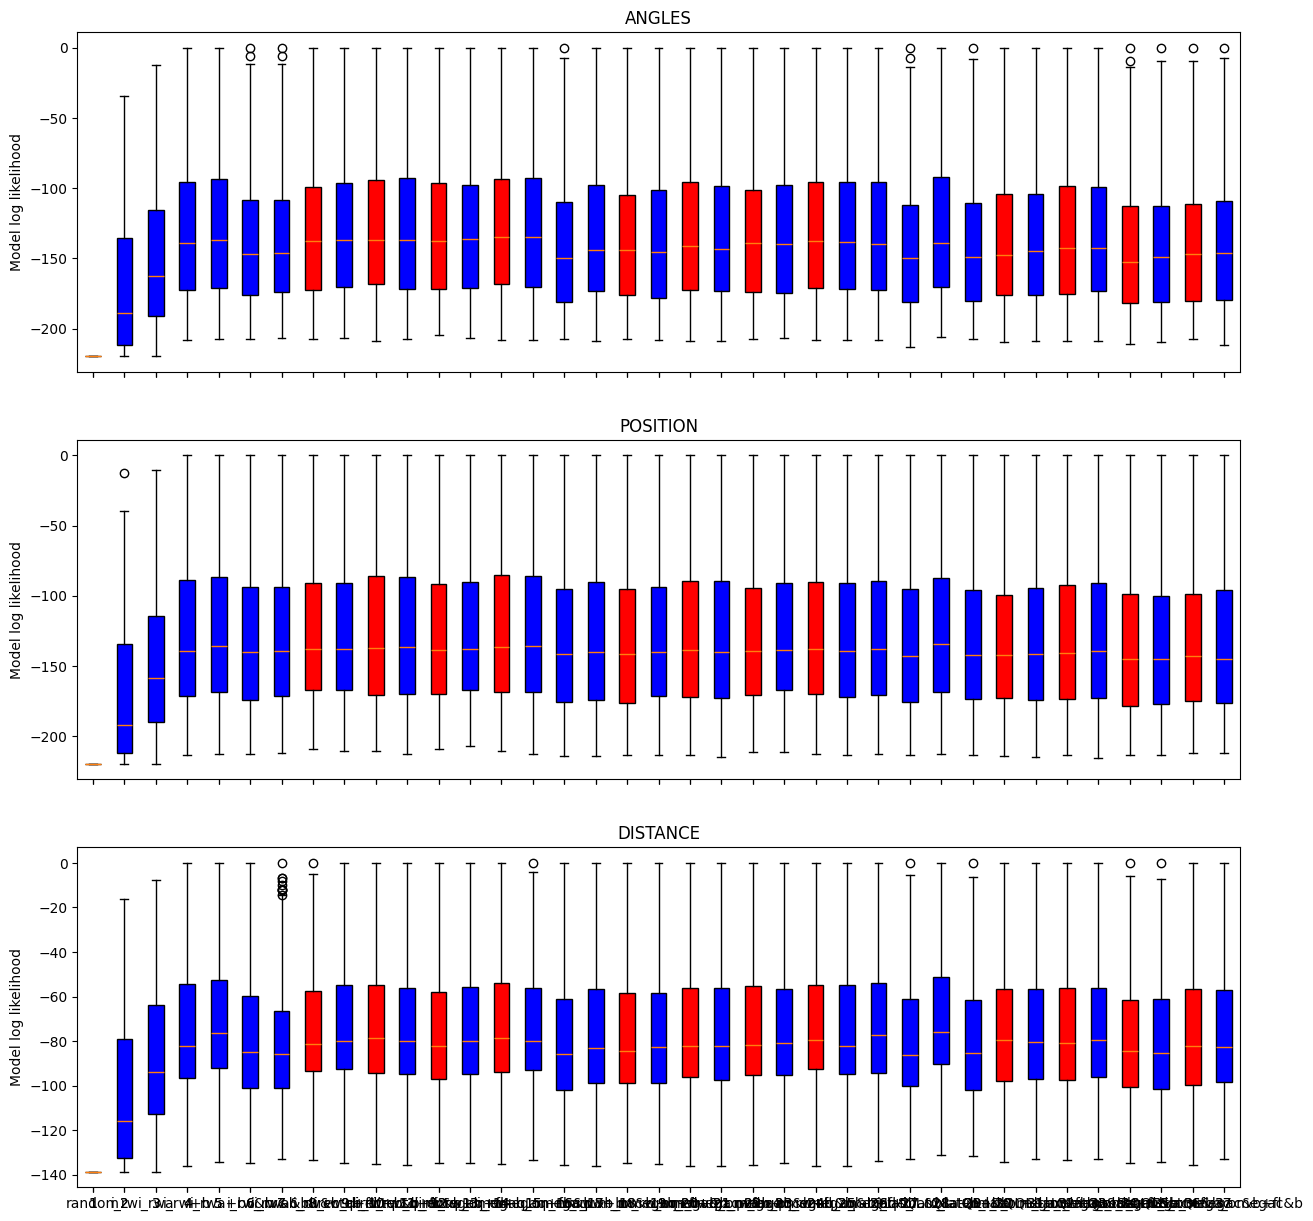

In [11]:
print("A total of {} models were inverted ! ".format(len(RESULTS)))

joint_dictionnary = {}
for model_name,results_contents in RESULTS.items():   
    joint_dictionnary[model_name] = MODEL_LIBRARY[model_name]
    
    for key,item in results_contents.items():
        joint_dictionnary[model_name][key] = item


best_global_fit,best_angle_fit,best_distance_fit,best_position_fit = {},{},{},{}
for model_name,model_results in joint_dictionnary.items():
    
    logliks,cross_entropies = model_results["logliks"]
    
    print(model_name)
    best_fit_total = np.max(logliks["angle"]+logliks["position"]+logliks["distance"],axis=-1)
    best_global_fit[model_name] = best_fit_total
    best_angle_fit[model_name] = np.max(logliks["angle"],axis=-1)
    best_distance_fit[model_name] = np.max(logliks["distance"],axis=-1)
    best_position_fit[model_name] = np.max(logliks["position"],axis=-1)
    
    model_loss_hist = model_results["losses_hist"]
    if model_loss_hist is not None:
        print(model_results["losses_hist"].shape)
    

# print(tabulate(parameter_count_list, headers=['model name', '# of parameters \n(scalar values)','# of parameters \n(distinct variables)'], tablefmt='orgtbl'))   

fig, ax = plt.subplots(figsize = (15,5))
ax.set_ylabel('Model log likelihood')

fits = best_global_fit.values()
labels = best_global_fit.keys()

bplot = ax.boxplot(fits,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks

for patch, model_name in zip(bplot['boxes'], labels):
    if 'fl' in model_name:
        color = 'red'
    else:
        color = 'blue'
    patch.set_facecolor(color)
ax.set_xticklabels(labels, rotation=30, ha='right')
plt.show()


fig, axs = plt.subplots(3,1,figsize = (15,15),sharex=True)

# Angle fits :
ax = axs[0]
ax.set_title("ANGLES")
ax.set_ylabel('Model log likelihood')
fits = best_angle_fit.values()
labels = best_angle_fit.keys()
bplot = ax.boxplot(fits,
                   patch_artist=True) 
for patch, model_name in zip(bplot['boxes'], labels):
    if 'fl' in model_name:
        color = 'red'
    else:
        color = 'blue'
    patch.set_facecolor(color)

# Position fits :
ax = axs[1]
ax.set_title("POSITION")
ax.set_ylabel('Model log likelihood')
fits = best_position_fit.values()
labels = best_position_fit.keys()
bplot = ax.boxplot(fits,
                   patch_artist=True) 
for patch, model_name in zip(bplot['boxes'], labels):
    if 'fl' in model_name:
        color = 'red'
    else:
        color = 'blue'
    patch.set_facecolor(color)

# Distance fits :
ax = axs[2]
ax.set_title("DISTANCE")
ax.set_ylabel('Model log likelihood')
fits = best_distance_fit.values()
labels = best_distance_fit.keys()
bplot = ax.boxplot(fits,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks
for patch, model_name in zip(bplot['boxes'], labels):
    if 'fl' in model_name:
        color = 'red'
    else:
        color = 'blue'
    patch.set_facecolor(color)
# ax.set_xticklabels(labels, rotation=30, ha='right')

plt.show()

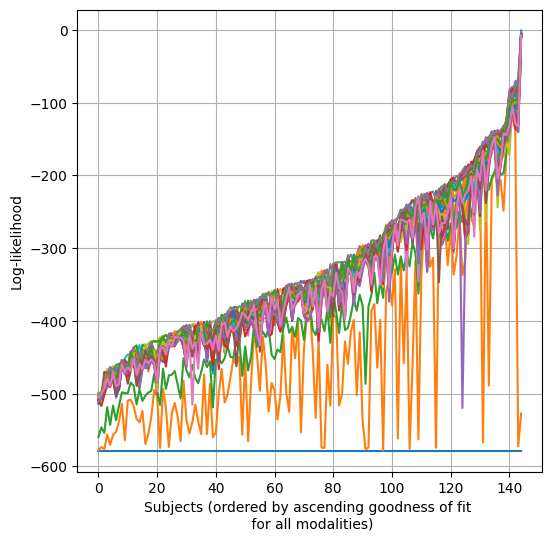

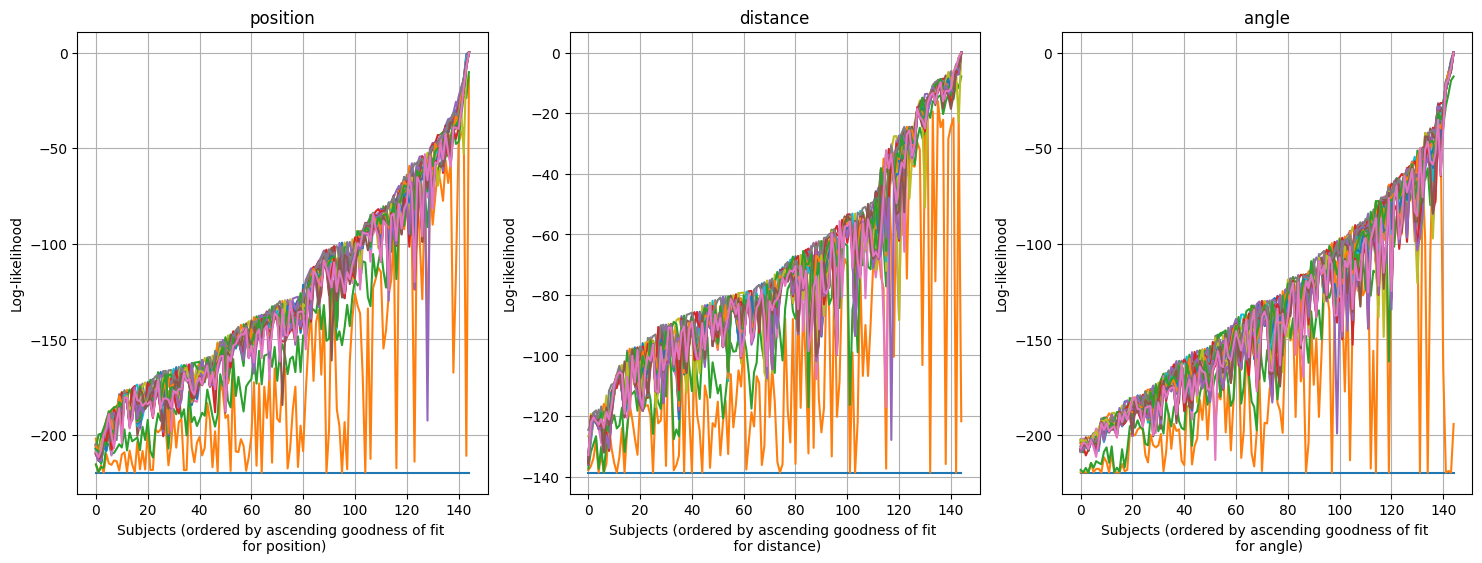

In [12]:

# Same figure with the most likely first :
fig,ax = plt.subplots(1,1,figsize=(6,6))
    
model_fit_table = np.sum(np.stack([[np.max(r['logliks'][0][action_mod],-1) for r in joint_dictionnary.values()] for action_mod in ["position","distance","angle"]]),axis=0)
indices = np.argsort(np.max(model_fit_table,0))
ordered_table = (model_fit_table[:,indices])
    
for i,(model,results) in enumerate(joint_dictionnary.items()):
    lls,ces = results["logliks"]
    
    # model_fit_table = np.stack([np.max(lls["logliks"],-1) for r in results_dict.values()])
    
    ax.plot(np.arange(Nsubj),ordered_table[i,:],label = model)

ax.set_ylabel("Log-likelihood")
ax.set_xlabel("Subjects (ordered by ascending goodness of fit \n for all modalities)")
ax.grid()
# ax.legend()


# Same figure with the most likely first :
fig,axs = plt.subplots(1,3,figsize=(6*3,6),sharex=True)
for k,action_mod in enumerate(["position","distance","angle"]):
    ax = axs[k] 
    
    model_fit_table = np.stack([np.max(r['logliks'][0][action_mod],-1) for r in joint_dictionnary.values()])
    indices = np.argsort(np.max(model_fit_table,0))
    ordered_table = (model_fit_table[:,indices])
        
    for i,(model,results) in enumerate(joint_dictionnary.items()):
        lls,ces = results["logliks"]
        
        # model_fit_table = np.stack([np.max(lls["logliks"],-1) for r in results_dict.values()])
        
        ax.plot(np.arange(Nsubj),ordered_table[i,:],label = model)

    ax.set_ylabel("Log-likelihood")
    ax.set_xlabel("Subjects (ordered by ascending goodness of fit \n for {})".format(action_mod))
    ax.set_title(action_mod)
    ax.grid()
# ax.legend()


[[-578.07434 -578.07434 -578.07434 ... -578.07434 -578.07434 -578.07434]
 [-135.14847 -486.55945 -499.4188  ... -400.87643 -566.93286 -498.9063 ]
 [-123.02548 -455.32645 -452.32507 ... -396.2312  -197.40662 -395.29352]
 ...
 [-141.9763  -428.82745 -460.13013 ... -371.24887 -175.89684 -372.97632]
 [-141.17648 -424.13574 -464.7904  ... -369.84476 -169.80455 -371.2483 ]
 [-135.54166 -426.52698 -452.8587  ... -366.7452  -169.04755 -369.76733]]
[[1156.1487  1156.1487  1156.1487  ... 1156.1487  1156.1487  1156.1487 ]
 [ 282.29697  994.0702  1014.8117  ...  813.76196 1147.9136  1091.5845 ]
 [ 270.03638  999.34973  923.9867  ...  833.83246  797.4304   979.37585]
 ...
 [1168.2424  1158.344   1117.9081  ...  783.98303 1175.7736  1174.166  ]
 [ 959.0826  1150.7935  1173.6073  ... 1070.0201  1169.0898  1178.1198 ]
 [1095.8892  1161.5503  1153.7341  ... 1148.7725  1178.2267  1175.8176 ]]
i_rw&b_omegaq+fl
i_latQL&b
i_latQLa&b
m_rw&b
m_rw+b
i_rw+b_directq+fl
i_rw+b_directq


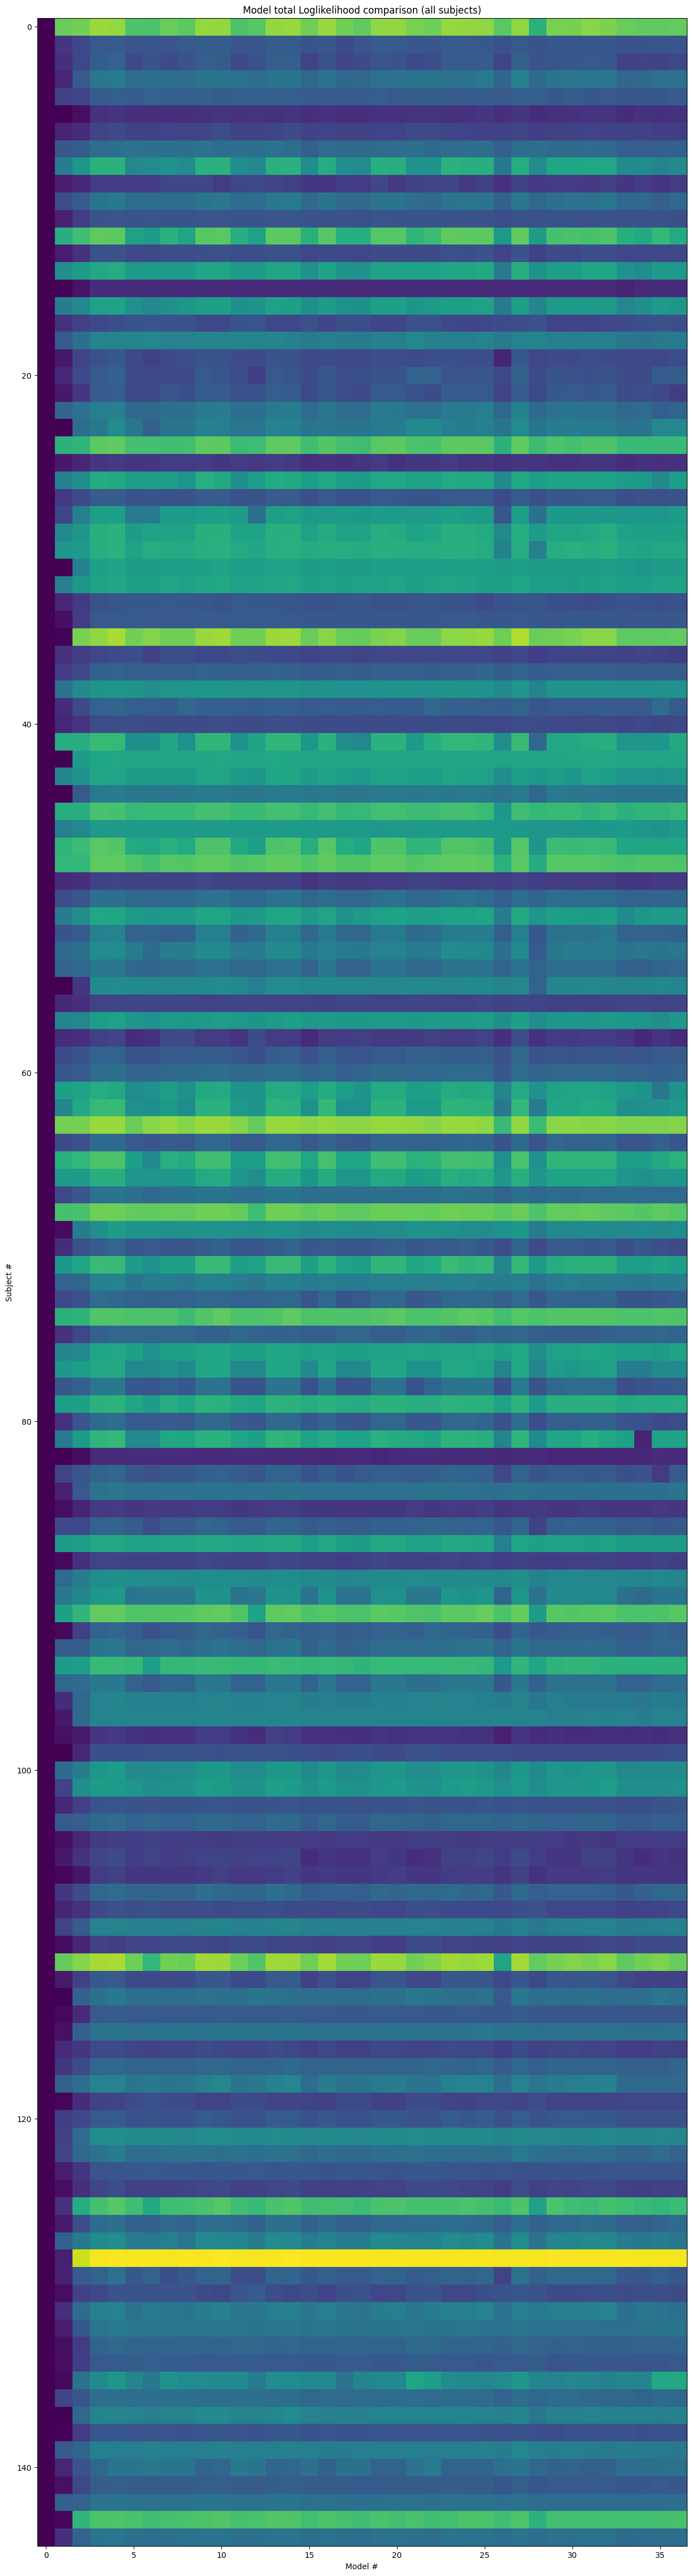

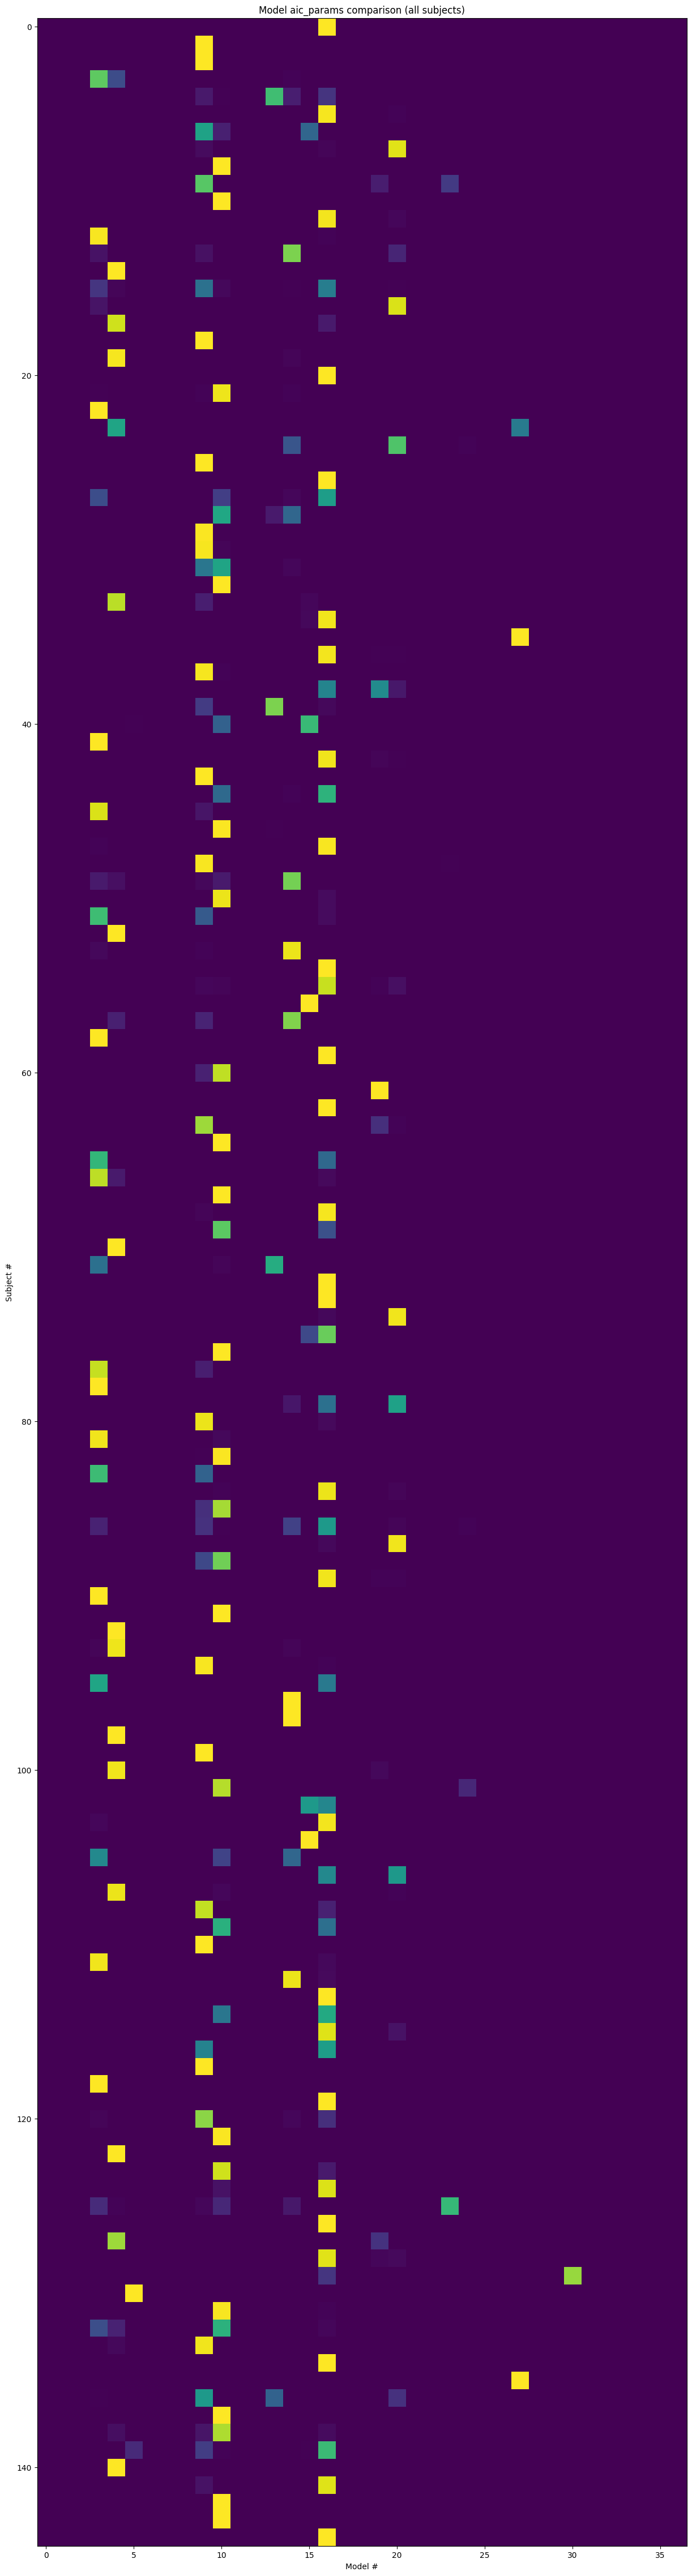

In [13]:


# # Get a typical hyperparameter dictionnary for each model :
# parameter_count_list = []
# for model_name,model_contents in MODEL_LIBRARY.items():   
#     parameter_set_tree = get_random_parameter_set(model_contents["ranges"],jr.PRNGKey(0))

    
#     vls,_ = (jax.tree.flatten(tree_map(lambda x : x.size,parameter_set_tree)))    
    
#     nbr,_ = (jax.tree.flatten(tree_map(lambda x : x.shape[0],parameter_set_tree)))    
    
#     parameter_count_list.append([model_name,sum(vls),sum(nbr)])#"{}({:.1f} %)".format(sum(nbr),(sum(nbr)+1e-10)/(sum(vls)+1e-10)*100)])

# print(tabulate(parameter_count_list, headers=['model name', '# of parameters \n(scalar values)','# of parameters \n(distinct variables)'], tablefmt='orgtbl'))   
 
 

for i,(model,model_contents) in enumerate(joint_dictionnary.items()):
    # Get # of params :
    parameter_set_tree = get_random_parameter_set(model_contents["ranges"],jr.PRNGKey(0))
    n_vls,_ = (jax.tree.flatten(tree_map(lambda x : x.size,parameter_set_tree)))    
    n_prms,_ = (jax.tree.flatten(tree_map(lambda x : x.shape[0],parameter_set_tree)))    
    
    model_contents["n_values"] = sum(n_vls)
    model_contents["n_params"] = sum(n_prms)

for i,(model,model_contents) in enumerate(joint_dictionnary.items()):
    lls,ces = model_contents["logliks"]

    stacked_lls = jnp.sum(jnp.stack(list(lls.values())),axis=0)
    
    n = ces["angle"][0,0,...].size  # Number of data points (for BIC)

    model_contents["total_ll"] = stacked_lls
    
    model_contents["aic_values"] = 2*model_contents["n_values"] - 2*stacked_lls
    model_contents["bic_values"] = 2*jnp.log(n)*model_contents["n_values"] - 2*stacked_lls
    
    model_contents["aic_params"] = 2*model_contents["n_params"] - 2*stacked_lls
    model_contents["bic_params"] = 2*jnp.log(n)*model_contents["n_params"] - 2*stacked_lls
    

# Figure : Likelihood Comparison for each subject :
N_subjects = joint_dictionnary["random"]["total_ll"].shape[0]
all_subjects_metrics = []
for model in joint_dictionnary.keys():
    all_subjects_metrics.append(np.max(joint_dictionnary[model]["total_ll"],axis=-1))

all_subjects_metrics = jnp.stack(all_subjects_metrics)

ratio = 0.4
fig,ax = plt.subplots(1,1,figsize=(all_subjects_metrics.shape[0]*ratio,all_subjects_metrics.shape[1]*ratio))
ax.imshow(all_subjects_metrics.T,aspect='auto',vmin=all_subjects_metrics[0,0],vmax=0)

ax.set_title("Model total Loglikelihood comparison (all subjects)")
ax.set_ylabel("Subject #")
ax.set_xlabel("Model #")

print(all_subjects_metrics)


# Figure : AIC / BIC Comparison for each subject :
metric = "aic_params"
N_subjects = joint_dictionnary["random"]["aic_params"].shape[0]
all_subjects_metrics = []
for model in joint_dictionnary.keys():
    
    all_subjects_metrics.append(np.max(joint_dictionnary[model][metric],axis=-1))

all_subjects_metrics = jnp.stack(all_subjects_metrics)

ratio = 0.4
fig,ax = plt.subplots(1,1,figsize=(all_subjects_metrics.shape[0]*ratio,all_subjects_metrics.shape[1]*ratio))
ax.imshow(-all_subjects_metrics.T,aspect='auto',vmin=-all_subjects_metrics[0,0],vmax=0)

ax.imshow(jax.nn.softmax(-all_subjects_metrics.T,axis=1),aspect='auto',vmin=0,vmax=1)

ax.set_title("Model " + metric + " comparison (all subjects)")
ax.set_ylabel("Subject #")
ax.set_xlabel("Model #")

# model_names = [joint_dictionnary.keys()]
# ax.set_xticks([k for k in range(len(model_names))],model_names,rotation=45, ha='right')

print(all_subjects_metrics)


# Did not like : 
print(list(joint_dictionnary.keys())[11])
print(list(joint_dictionnary.keys())[26])
print(list(joint_dictionnary.keys())[28])

# Liked : 
print(list(joint_dictionnary.keys())[15])
print(list(joint_dictionnary.keys())[16])


print(list(joint_dictionnary.keys())[9])
print(list(joint_dictionnary.keys())[10])